Imports

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 20.3 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224709 sha256=87e7e235d36e3b25a27bdd9dd1729c852e2d992a16487f1f2b827dcc1096765a
  Stored in directory: /root/.cache/pip/wheels/d4/33/ed/aaac5a347fb8d41679ca515b8f5c49dfdf49be15bdbb9a905d
Successfully built medpy


/content
data_utilities_v2.py  __pycache__  sample_data
/bin/bash: line 1: cd../: No such file or directory


In [2]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from datetime import datetime
from tqdm import tqdm
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, ConvLSTM2D, Softmax, Lambda
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation, Conv3DTranspose, UpSampling3D, Concatenate, LayerNormalization, ReLU, Add, Multiply
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.backend import clear_session
from scipy.spatial.distance import directed_hausdorff
import sys
sys.path.append(os.path.abspath('/content/data_utilities_v2.py'))
from data_utilities_v2 import *


In [3]:
clear_session()

In [4]:
# Check if TensorFlow is built with GPU support
print("Built with GPU support:", tf.test.is_built_with_cuda())

# List available physical devices (CPU/GPU)
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Number of GPUs available: {len(physical_devices)}")
    for i, gpu in enumerate(physical_devices):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU available.")

Built with GPU support: True
Number of GPUs available: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# File Format Requirements:
# 1. Input Data Structure:
#    - The data should be organized in a directory structure as follows:
#      raw_data/
#        |- <patient_number>/
#        |   |- <mzp_folder>/
#        |       |- VL_<mzp_folder>_<patient_number>.nrrd
#        |       |- Segmentation_VL_<mzp_folder>_<patient_number>.seg.nrrd
#    - Example:
#      raw_data/
#        |- 001/
#        |   |- MZP1/
#        |       |- VL_MZP1_001.nrrd
#        |       |- Segmentation_VL_MZP1_001.seg.nrrd
#        |   |- MZP2/
#        |       |- VL_MZP2_001.nrrd
#        |       |- Segmentation_VL_MZP2_001.seg.nrrd
#
# 2. File Naming Conventions:
#    - Volume file: `VL_<mzp_folder>_<patient_number>.nrrd`
#    - Mask file: `Segmentation_VL_<mzp_folder>_<patient_number>.seg.nrrd`
#
# 3. Output Data Structure:
#    - The results will be saved in a mirrored directory structure under `analyzed_data`:
#      analyzed_data/
#        |- <patient_number>/
#        |   |- <mzp_folder>/
#        |       |- volume/
#        |       |   |- volume_000.tif
#        |       |   |- volume_001.tif
#        |       |- mask/
#        |           |- mask_000.tif
#        |           |- mask_001.tif
#
# Usage:
# - To process all patients in the `raw_data` directory, use the batch processing function.
# - To process a single patient, provide the exact file paths for the volume and mask files.

In [ ]:

import os
import nrrd
import numpy as np
from PIL import Image
import shutil

def create_output_folder(output_folder_path):
    """
    Clears and creates the subfolders for the masks and volume .tif files.

    Output Folder Structure:
    - output_folder_path/
        - volume/ : contains the .tif slices for the volume data
        - mask/   : contains the .tif slices for the mask data

    Args:
    - output_folder_path: the base path for the output folders (volume and mask)
    """
    output_folder_volume = os.path.join(output_folder_path, "volume")  # volume tiff folder
    output_folder_mask = os.path.join(output_folder_path, "mask")      # mask tiff folder

    # Remove and recreate folders
    for folder in [output_folder_volume, output_folder_mask]:
        if os.path.exists(folder):
            shutil.rmtree(folder)  # Remove all contents of the folder
        os.makedirs(folder, exist_ok=True)  # Recreate the folder

def crop_image_get_bounds(image, threshold):
    """
    Calculate cropping bounds dynamically based on the threshold.
    Args:
    - image: 2D numpy array to crop
    - threshold: minimum pixel intensity to consider as non-black
    Returns:
    - cropping bounds (rmin, rmax, cmin, cmax) or None if the image is completely black
    """

    rows = np.any(image > threshold, axis=1)
    cols = np.any(image > threshold, axis=0)

    if not np.any(rows) or not np.any(cols):  # Check if the image is black
        return None

    # Find significant borders
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def apply_crop(image, bounds):
    """
    Apply cropping bounds to the image.
    Args:
    - image: 2D numpy array to crop
    - bounds: cropping bounds (rmin, rmax, cmin, cmax)
    Returns:
    - Cropped image or None if bounds are invalid
    """
    if bounds is None:
        return None
    rmin, rmax, cmin, cmax = bounds
    return image[rmin:rmax+1, cmin:cmax+1]

def export_to_tif_with_threshold(volume_data, mask_data, output_dir_volume, output_dir_mask, threshold=10):
    """
    Exports a 3D array to .tif files, one slice per file, after cropping and normalization.
    Args:
    - volume_data: 3D numpy array of the volume
    - mask_data: 3D numpy array of the mask
    - output_dir_volume: folder to save the volume slices
    - output_dir_mask: folder to save the mask slices
    - threshold: pixel intensity threshold for black image filtering
    """
    exported_count = 0  # Count valid slices

    for i in range(volume_data.shape[2]):  # Loop through each slice
        slice_volume = volume_data[:, :, i]
        slice_mask = mask_data[:, :, i]

        # Apply the mask
        masked_volume = slice_volume * slice_mask

        # Check if the masked volume is black
        if not np.any(masked_volume > threshold):
            continue

        # Calculate cropping bounds from the volume slice
        bounds = crop_image_get_bounds(slice_volume, threshold)

        # Crop both volume and mask using the same bounds
        cropped_volume = apply_crop(slice_volume, bounds)
        cropped_mask = apply_crop(slice_mask, bounds)

        # Skip if the cropped slice is black or invalid
        if cropped_volume is None or cropped_mask is None:
            continue

        # Normalize the slices to range [0, 255]
        volume_normalized = ((cropped_volume - np.min(cropped_volume)) /
                            (np.ptp(cropped_volume) + 1e-5) * 255).astype(np.uint8)
        mask_normalized = ((cropped_mask - np.min(cropped_mask)) /
                          (np.ptp(cropped_mask) + 1e-5) * 255).astype(np.uint8)

        # Save slices as .tif files
        volume_path = os.path.join(output_dir_volume, f"volume_{exported_count:03d}.tif")
        mask_path = os.path.join(output_dir_mask, f"mask_{exported_count:03d}.tif")
        Image.fromarray(volume_normalized).save(volume_path)
        Image.fromarray(mask_normalized).save(mask_path)

        exported_count += 1

def process_raw_data(raw_data_path, analyzed_data_path, threshold=10):
    """
    Process all patient subdirectories to crop and export volume and mask data.
    Args:
    - raw_data_path: base path of the raw data directory *The segmentation and the volume need to be saved in the following way: VL_MZP#_patientnumber.nrrd, Segmentation_VL_MZP#_patientnumber.seg.nrrd*
    - analyzed_data_path: base path for the output directory
    - threshold: pixel intensity threshold for black image filtering
    """
    for patient_folder in sorted(os.listdir(raw_data_path)):
        patient_path = os.path.join(raw_data_path, patient_folder)
        if not os.path.isdir(patient_path):
            continue

        for mzp_folder in sorted(os.listdir(patient_path)):
            mzp_path = os.path.join(patient_path, mzp_folder)
            if not os.path.isdir(mzp_path):
                continue

            # Construct file names dynamically using patient number and MZP folder
            patient_number = patient_folder
            volume_file = os.path.join(mzp_path, f"VL_{mzp_folder}_{patient_number}.nrrd")
            mask_file = os.path.join(mzp_path, f"Segmentation_VL_{mzp_folder}_{patient_number}.seg.nrrd")

            if os.path.exists(volume_file) and os.path.exists(mask_file):
                # Read the volume and mask data
                volume_data, _ = nrrd.read(volume_file)
                mask_data, _ = nrrd.read(mask_file)

                # Define output folder for the current MZP
                output_folder = os.path.join(analyzed_data_path, patient_folder, mzp_folder)
                create_output_folder(output_folder)

                # Export to .tif
                output_volume_dir = os.path.join(output_folder, "volume")
                output_mask_dir = os.path.join(output_folder, "mask")
                export_to_tif_with_threshold(volume_data, mask_data, output_volume_dir, output_mask_dir, threshold=threshold)

# Paths for input and output data
raw_data_path = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/raw_data"
analyzed_data_path = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/analyzed_data"

# Process all patient data
process_raw_data(raw_data_path, analyzed_data_path, threshold=10)


In [ ]:
import os
import nrrd
import numpy as np
from PIL import Image
import shutil
def process_single_patient(patient_number, mzp_folder, volume_file_path, mask_file_path, analyzed_data_path, threshold=10):
    """
    Process a single patient's MZP folder to crop and export volume and mask data.
    Args:
    - patient_number: the patient ID (e.g., '001')
    - mzp_folder: the MZP folder name (e.g., 'MZP1')
    - volume_file_path: path to the volume .nrrd file
    - mask_file_path: path to the mask .nrrd file
    - analyzed_data_path: base path for the output directory
    - threshold: pixel intensity threshold for black image filtering
    """
    if not os.path.exists(volume_file_path) or not os.path.exists(mask_file_path):
        raise FileNotFoundError("Volume or mask file does not exist.")

    # Read the volume and mask data
    volume_data, _ = nrrd.read(volume_file_path)
    mask_data, _ = nrrd.read(mask_file_path)

    # Define output folder for the current MZP
    output_folder = os.path.join(analyzed_data_path, patient_number, mzp_folder)
    create_output_folder(output_folder)

    # Export to .tif
    output_volume_dir = os.path.join(output_folder, "volume")
    output_mask_dir = os.path.join(output_folder, "mask")
    export_to_tif_with_threshold(volume_data, mask_data, output_volume_dir, output_mask_dir, threshold=threshold)

# Example usage for a single patient
patient_number = "001"
mzp_folder = "MZP1"
volume_file_path = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/raw_data/001/MZP1/VL_MZP1_001.nrrd"
mask_file_path = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/raw_data/001/MZP1/Segmentation_VL_MZP1_001.seg.nrrd"
analyzed_data_path = "C:/Users/diego/Bac Sport and Computer Science/BA-arbeit/RepoBA/BA-IFSS/data/analyzed_data"

process_single_patient(patient_number, mzp_folder, volume_file_path, mask_file_path, analyzed_data_path, threshold=10)

## Loss definitions

In [5]:
# taken from https://github.com/nabsabraham/focal-unet/blob/master/losses.py


epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    smooth = 1.
    axis = (1,2,3,4)
    #y_true_f = K.flatten(y_true)
    #y_pred_f = K.flatten(y_pred)
    y_true_f = tf.reduce_sum(y_true, axis=axis)
    y_pred_f = tf.reduce_sum(y_pred, axis=axis)

    intersection = tf.reduce_sum(y_true * y_pred)

    #score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    score = (2. * intersection + smooth) / (y_true_f + y_pred_f + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth)
    return tp

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn

def tversky(y_true, y_pred):
    # Ensure both y_true and y_pred are of the same type (float32)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    axis = (1,2,3,4)
    P_foreground = y_pred[:,:,:,:,:1]
    P_background = y_pred[:,:,:,:,1:]
    g_foreground = y_true[:,:,:,:,:1]
    g_background = y_true[:,:,:,:,1:]

    #y_true_pos = K.flatten(y_true)
    #y_pred_pos = K.flatten(y_pred)
    true_pos = P_foreground * g_foreground
    true_pos = tf.reduce_sum(true_pos, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5*tf.reduce_sum(false_neg, axis=axis)

    #true_pos = K.sum(y_true_pos * y_pred_pos)
    #false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    #false_pos = K.sum((1 - y_true_pos) * y_pred_pos)

    alpha = 0.7
    smooth = 1e-6

    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def IoU(y_true, y_pred, smooth: int = 1) -> float:
    # Caclulate Intersection
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    # Calculate Union
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    # Calculate IoU
    iou = (intersection + smooth) / (union + smooth)

    return iou

## Definition of IFSS utilities

In [6]:
def Conv3DBlock(
    inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn="relu"
):
    """
    Builds the 3d conv block
    Apply successivly a 3D convolution, BatchNormalization and relu
    """
    # Skip pointwise by setting num_outputs=Non
    net = Conv3D(
        filters=n_filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
    )(inputs)
    net = BatchNormalization()(net)
    #net = LayerNormalization()(net)
    net = Activation(activation_fn)(net)

    return net

def Conv3DBlockTranspose(
    inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn="relu"
):
    """
    Builds the 3d conv transpose block
    Apply successivly a 3D transpose convolution, BatchNormalization and relu
    """
    # Skip pointwise by setting num_outputs=Non
    net = Conv3DTranspose(
        filters=n_filters,
        kernel_size=kernel_size,
        strides=stride,
        padding="same",
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
    )(inputs)
    net = BatchNormalization()(net)
    #net = LayerNormalization()(net)
    net = Activation(activation_fn)(net)

    return net


def AtrousSpatialPyramidPoolingModule_3D(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )


    atrous_pool_block_1 = Conv3D(depth, (1, 1, 1), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None)(inputs)

    atrous_pool_block_6 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(12, 12, 12), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(18, 18, 18), kernel_initializer=GlorotUniform(), kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net


def AtrousSpatialPyramidPoolingModule_3D_rate_9(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )

    atrous_pool_block_1 = Conv3D(
        depth,
        (1, 1, 1),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(inputs)

    atrous_pool_block_6 = Conv3D(
        depth,
        (1, 1, 1),
        dilation_rate=(2, 2, 2),
        kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4),
        activation=None,
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(4, 4, 4), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net

def AtrousSpatialPyramidPoolingModule_3D_rate_11(inputs, depth=256):
    """
    5D Tensor: batch, time, H, W, C
    """
    # feature_map_size = tf.shape(inputs)

    # Global average pooling
    image_features = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True)
    )(inputs)

    image_features = Conv3D(depth, (1, 1, 1),kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None)(image_features)

    image_features = UpSampling3D(size=(1, int(inputs.shape[2]), int(inputs.shape[3])))(
        image_features
    )

    atrous_pool_block_1 = Conv3D(depth, (1, 1, 1), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None)(inputs)

    atrous_pool_block_6 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(4, 4, 4), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_12 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(6, 6, 6), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    atrous_pool_block_18 = Conv3D(
        depth, (1, 1, 1), dilation_rate=(8, 8, 8), kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(inputs)

    net = Concatenate(axis=-1)(
        [
            image_features,
            atrous_pool_block_1,
            atrous_pool_block_6,
            atrous_pool_block_12,
            atrous_pool_block_18,
        ]
    )

    return net

def AttentionRefinementModule_3D(inputs, n_filters):
    "for 3d data"
    # 3D Global average pooling
    net = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)

    #net = LayerNormalization()(net)
    net = BatchNormalization()(net)
    net = tf.sigmoid(net)
    net = tf.multiply(inputs, net)

    return net

def FeatureFusionModule(input_1, input_2, n_filters):

    #inputs = Concatenate()([input_1, input_2])
    inputs = Concatenate(axis=-1)([input_1, input_2])

    inputs = Conv3DBlock(
        inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 1, 1], activation_fn=None
    )

    # Global average pooling
    net = Lambda(lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True))(inputs)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    net = ReLU()(net)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)

    net = Lambda(lambda x: tf.sigmoid(x))(net)

    net = Multiply()([inputs, net])
    net = Add()([inputs, net])

    return net

def FeatureFusionModule_with_Stirde(input_1, input_2, n_filters):

    #inputs = tf.concat([input_1, input_2], axis=-1)
    inputs = Concatenate(axis=-1)([input_1, input_2])

    inputs = Conv3DBlock(
        inputs, n_filters, kernel_size=[3, 3, 3], stride=[1, 2, 2], activation_fn=None
    )

    # Global average pooling
    #net = tf.reduce_mean(inputs, axis=[2, 3], keepdims=True)
    net = Lambda(lambda x: tf.reduce_mean(x, axis=[2, 3], keepdims=True))(inputs)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)
    net = ReLU()(net)

    net = Conv3D(
        filters=n_filters, kernel_size=(1, 1, 1), padding="same", kernel_initializer=GlorotUniform(),  # Xavier initializer
        kernel_regularizer=l2(1e-4), activation=None
    )(net)

    #net = tf.sigmoid(net)
    net = Lambda(lambda x: tf.sigmoid(x))(net)

    net = Multiply()([inputs, net])
    net = Add()([inputs, net])

    return net

def Tversky_sigmoid(
    prediction, ground_truth, alpha=0.25, axis=(1, 2, 3, 4), smooth=1.0
):
    """
    prediction is the probabilities from sigmoid. Only one channel is provided and backgorund is estimated
    """

    P_foreground = prediction
    P_background = 1 - prediction

    g_foreground = ground_truth
    g_background = 1 - ground_truth

    true_positive = tf.reduce_sum(P_foreground * g_foreground, axis=axis)
    false_pos = tf.reduce_sum(P_foreground * g_background, axis=axis)
    false_neg = tf.reduce_sum(P_background * g_foreground, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth,
        true_positive + (alpha * false_pos) + ((1 - alpha) * false_neg) + smooth,
    )

    return 1 - tf.reduce_mean(Tversky)


def focal_tversky_sigmoid(prediction, ground_truth, alpha):
    Tversly_loss = Tversky_sigmoid(prediction, ground_truth, alpha)
    gamma = 2
    return tf.pow(-tf.math.log(Tversly_loss), gamma)


def Tversky_softmax(
    prediction,
    ground_truth,
    keep_prob_tp,
    keep_prob_alpha,
    keep_prob_beta,
    axis=(1, 2, 3, 4),
):
    """
    prediction is the probabilities from softmax
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    P_foreground = tf.nn.dropout(
        P_foreground, rate=1 - (keep_prob_tp), name="P_foreground_drop_out"
    )

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = keep_prob_alpha * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = keep_prob_beta * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky)


def focal_tversky_softmax(
    prediction, ground_truth, keep_prob_tp, keep_prob_alpha, keep_prob_beta
):
    Tversly_loss = Tversky_softmax(
        prediction, ground_truth, keep_prob_tp, keep_prob_alpha, keep_prob_beta
    )
    gamma = 2
    return tf.pow(1 - Tversly_loss, gamma)

def Tversky_Index(prediction, ground_truth, axis=(1, 2, 3, 4)):
    """
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = 0.5 * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5 * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky)

def dice_coe(output, target, loss_type="sorensen", axis=(1, 2, 3, 4), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity"""
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == "jaccard":
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == "sorensen":
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # new haodong
    dice = (2.0 * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name="dice_coe")
    return dice


def iou_coe(output, target, threshold=0.5, axis=(1, 2, 3, 4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity"""
    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(
        tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis
    )  # OR

    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, name="iou_coe")
    return iou  # , pre, truth, inse, union


def dice_hard_coe(output, target, threshold=0.5, axis=(1, 2, 3, 4), smooth=1e-5):
    """Non-differentiable Sørensen–Dice coefficient for comparing the similarity"""
    output = tf.cast(output > threshold, dtype=tf.float32)
    target = tf.cast(target > threshold, dtype=tf.float32)
    inse = tf.reduce_sum(tf.multiply(output, target), axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)
    hard_dice = (2.0 * inse + smooth) / (l + r + smooth)
    ##
    hard_dice = tf.reduce_mean(hard_dice, name="hard_dice")
    return hard_dice

def confusion(y_true, y_pred):
    smooth = 1

    y_pred_pos = tf.clip_by_value(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos

    y_pos = tf.clip_by_value(y_true, 0, 1)
    y_neg = 1 - y_pos

    tp = tf.reduce_sum(y_pos * y_pred_pos)
    fp = tf.reduce_sum(y_neg * y_pred_pos)
    fn = tf.reduce_sum(y_pos * y_pred_neg)


    prec = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)

    return prec, recall

def Downsampling_2D(inputs, scale1, scale2):
    return tf.image.resize(
        inputs, size=[scale1, scale2], method=tf.image.ResizeMethod.BILINEAR
    )


def Down_sample_3D(input_layer, scale1, scale2):
    """
    TODO : 10 should be changed to new time scale 10 30 or 200
    """
    unpol_layer = tf.map_fn(
        lambda layer: Downsampling_2D(layer, scale1, scale2),
        input_layer,
        dtype=tf.float32,
    )

    return tf.transpose(tf.stack(unpol_layer), [1, 0, 2, 3, 4])

def skip(layer, end_point):
    return tf.concat([layer, end_point], axis=4)  # -1


def unpool(layer):
    height = layer.shape[1] * 2
    width = layer.shape[2] * 2
    return tf.image.resize(
        layer, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )


def unpool_3D_2(input_layer):

    unpol_layer = tf.map_fn(lambda layer: unpool(layer), input_layer, dtype=tf.float32)
    return tf.transpose(tf.stack(unpol_layer), [1, 0, 2, 3, 4])


def unpool_3D(input_layer):

    unpol_layer = tf.keras.layers.UpSampling3D(size=(1, 2, 2))(input_layer)
    return unpol_layer


# Re-define for 5D Tensor, here we are dealing with 5D: axis=3 become axis=4 last channel
def pixel_wise_softmax(output_map):
    return layers.Softmax(axis=-1, name="softmax_output")(output_map)


def weight_variable(shape):

    weights_initializer = tf.keras.initializers.VarianceScaling(
        scale=1.0,
        mode="fan_avg",
        distribution="uniform" if True else "truncated_normal",
        seed=None,
        dtype=tf.float32,
    )
    Weight = tf.Variable(weights_initializer(shape=shape))

    return Weight


def weight_variable2(shape):

    weights_initializer = tf.keras.initializers.RandomUniform(
        minval=0.5, maxval=0.5, seed=None
    )
    Weight = tf.Variable(weights_initializer(shape=shape))

    return Weight


def create_folder_subfolders(proposedPath):
    """

    Create a folder and sub folders for each of the foreground and background using a proposed path.
    """

    # GL
    newpathGLL = proposedPath + "/GL"
    if os.path.exists(newpathGLL) is True:
        pass
    else:
        os.mkdir(newpathGLL)

    newpathGLFF = newpathGLL + "/F"
    newpathGLBB = newpathGLL + "/B"

    if os.path.exists(newpathGLFF) is True:
        pass
    elif os.path.exists(newpathGLBB) is True:
        pass
    else:
        os.mkdir(newpathGLFF)
        os.mkdir(newpathGLBB)

    # GM
    newpathGMM = proposedPath + "/GM"
    if os.path.exists(newpathGMM) is True:
        pass
    else:
        os.mkdir(newpathGMM)

    newpathGMFF = newpathGMM + "/F"
    newpathGMBB = newpathGMM + "/B"

    if os.path.exists(newpathGMFF) is True:
        pass
    elif os.path.exists(newpathGMBB) is True:
        pass
    else:
        os.mkdir(newpathGMFF)
        os.mkdir(newpathGMBB)

    # SOL
    newpathSOLL = proposedPath + "/SOL"
    if os.path.exists(newpathSOLL) is True:
        pass
    else:
        os.mkdir(newpathSOLL)

    newpathSOLFF = newpathSOLL + "/F"
    newpathSOLBB = newpathSOLL + "/B"

    if os.path.exists(newpathSOLFF) is True:
        pass
    elif os.path.exists(newpathSOLBB) is True:
        pass
    else:
        os.mkdir(newpathSOLFF)
        os.mkdir(newpathSOLBB)

    return (
        newpathGLFF,
        newpathGLBB,
        newpathGMFF,
        newpathGMBB,
        newpathSOLFF,
        newpathSOLBB,
    )

def create_folder_subfoldersMASK(proposedPath):
    """

    Create a folder and sub folders for each of the foreground and background using a proposed path.
    """

    # GL
    newpathGLL = proposedPath + "/GL"
    if os.path.exists(newpathGLL) is True:
        pass
    else:
        os.mkdir(newpathGLL)

    newpathGLFF = newpathGLL + "/F_mask"
    newpathGLBB = newpathGLL + "/B_mask"

    if os.path.exists(newpathGLFF) is True:
        pass
    elif os.path.exists(newpathGLBB) is True:
        pass
    else:
        os.mkdir(newpathGLFF)
        os.mkdir(newpathGLBB)

    # GM
    newpathGMM = proposedPath + "/GM"
    if os.path.exists(newpathGMM) is True:
        pass
    else:
        os.mkdir(newpathGMM)

    newpathGMFF = newpathGMM + "/F_mask"
    newpathGMBB = newpathGMM + "/B_mask"

    if os.path.exists(newpathGMFF) is True:
        pass
    elif os.path.exists(newpathGMBB) is True:
        pass
    else:
        os.mkdir(newpathGMFF)
        os.mkdir(newpathGMBB)

    # SOL
    newpathSOLL = proposedPath + "/SOL"
    if os.path.exists(newpathSOLL) is True:
        pass
    else:
        os.mkdir(newpathSOLL)

    newpathSOLFF = newpathSOLL + "/F_mask"
    newpathSOLBB = newpathSOLL + "/B_mask"

    if os.path.exists(newpathSOLFF) is True:
        pass
    elif os.path.exists(newpathSOLBB) is True:
        pass
    else:
        os.mkdir(newpathSOLFF)
        os.mkdir(newpathSOLBB)

    return (
        newpathGLFF,
        newpathGLBB,
        newpathGMFF,
        newpathGMBB,
        newpathSOLFF,
        newpathSOLBB,
    )


def iou_coe_Slice_by_Slice(output, target, threshold=0.5, axis=(2, 3, 4), smooth=1e-5):
    """Non-differentiable Intersection over Union (IoU) for comparing the similarity"""

    pre = tf.cast(output > threshold, dtype=tf.float32)
    truth = tf.cast(target > threshold, dtype=tf.float32)

    inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
    union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)

    batch_iou = (inse + smooth) / (union + smooth)
    iou = tf.reduce_mean(batch_iou, axis=0, name="iou_coe")

    return iou  # , pre, truth, inse, union


def Tversky_Index_Slice_by_Slice(prediction, ground_truth, axis=(2, 3, 4)):
    """
    prediction is the probabilities from softmax, here it act as Dice Coef, as alpha and beta
    """
    smooth = 1
    P_foreground = prediction[..., :1]
    P_background = prediction[..., 1:]
    g_foreground = ground_truth[..., :1]
    g_background = ground_truth[..., 1:]

    true_positive = P_foreground * g_foreground
    true_positive = tf.reduce_sum(true_positive, axis=axis)

    false_pos = P_foreground * g_background
    false_pos = 0.5 * tf.reduce_sum(false_pos, axis=axis)

    false_neg = P_background * g_foreground
    false_neg = 0.5 * tf.reduce_sum(false_neg, axis=axis)

    Tversky = tf.divide(
        true_positive + smooth, (true_positive + false_pos + false_neg + smooth)
    )

    return tf.reduce_mean(Tversky, axis=0)


# Hausdorff Distance
def HausdorffDist(A, B):

    A_squared = np.sum(A**2, axis=1, keepdims=True)
    B_squared = np.sum(B**2, axis=1, keepdims=True)
    D_mat = np.sqrt(A_squared - 2 * np.dot(A, B.T) + B_squared.T)

    # Find DH
    max_dist_A_to_B = np.max(np.min(D_mat, axis=1))
    max_dist_B_to_A = np.max(np.min(D_mat, axis=0))
    dH = np.max([max_dist_A_to_B, max_dist_B_to_A])

    return dH


def ComputeHDD(A, B):
    """A and B has the following Shape
    tensor of 3d: batch, H, W
    """
    return list(map(lambda a, b: HausdorffDist(a, b), A, B))

def HausdorffDistance(A, B):

    #A = tf.reshape(A, (A.shape[2], A.shape[3]))
    #B = tf.reshape(A, (B.shape[2], B.shape[3]))
    A = tf.squeeze(A)
    B = tf.squeeze(B)

    def compute_distance(a, b):

        points1 = np.argwhere(a>0)
        points2 = np.argwhere(b>0)

        d1 = directed_hausdorff(points1, points2)[0]
        d2 = directed_hausdorff(points2, points1)[0]

        return max(d1, d2)

    hausdorff_distance = tf.numpy_function(compute_distance, [A,B], tf.double)

    return hausdorff_distance


def process_data_with_spacing(data_file_path):
    """
    Return 3 masks in order SOL, GL and GM.
    Input: main path for the dataset: either Train/Val/or Testm i.e. '/tf/volumes/train/CAT_TH/masksX1.mha'
    """

    # Read the data of formate (528, 640, 1574)
    image_data, HEADER = load(data_file_path)
    # Adjust the formate to (640, 528, 1574)
    image_data = image_data.transpose([1, 0, 2])

    image_data = list(
        map(
            lambda mask_time_step: crop_pad(mask_time_step),
            image_data.transpose(2, 0, 1),
        )
    )  # ,(512,640),

    return np.array(image_data), HEADER.spacing


def Pull_data_from_path_with_spacing(path):
    data, SPACING = process_data_with_spacing(path)
    # return normalized data
    # values from whole data
    mean_val = 19.027262640214904
    std_val = 34.175155632916

    data = (data - mean_val) / std_val
    # reshape to t,h,w,1
    return np.expand_dims(data, -1), SPACING


## Definition of IFSS neural network and compile

In [7]:

# Definition of IFSS neural network and compile
def create_model(input_shape_x, input_shape_y, num_classes, keep_prob_skip=0.2):
    x_target = tf.keras.Input(shape=input_shape_x, name='x_target')
    y_estimated = tf.keras.Input(shape=input_shape_y, name='y_estimated')
    #print(x_target)
    #print(y_estimated)

    ################# Layer 1
    Layer_1 = Conv3DBlock(x_target, n_filters=30, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_1p')(Layer_1)
    Layer_1 = AtrousSpatialPyramidPoolingModule_3D(Layer_1, depth=6)
    Layer_1 = Dropout(rate=1 - keep_prob_skip)(Layer_1)
    #print(Layer_1)

    ################ Layer 2
    Layer_2 = Conv3DBlock(Layer_1, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_2 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_2p')(Layer_2)
    Layer_2 = AtrousSpatialPyramidPoolingModule_3D(Layer_2, depth=6)
    Layer_2 = Dropout(rate=1 - keep_prob_skip)(Layer_2)
    #print(Layer_2)

    ############### Layer 3
    Layer_3 = Conv3DBlock(Layer_2, 60, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_3 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_3p')(Layer_3)
    Layer_3 = AtrousSpatialPyramidPoolingModule_3D_rate_11(Layer_3, depth=12)
    Layer_3 = Dropout(rate=1 - keep_prob_skip)(Layer_3)
    #print(Layer_3)

    ############## Layer 4
    Layer_4 = Conv3DBlock(Layer_3, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_4 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_4p')(Layer_4)
    Layer_4 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_4, depth=24)
    Layer_4 = Dropout(rate=1 - keep_prob_skip)(Layer_4)
    #print(Layer_4)

    ############## Layer 5

    Layer_5 = Conv3DBlock(Layer_4, 120, kernel_size=(3, 3, 3), stride=(1, 1, 1), activation_fn=None)
    Layer_5 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same', name='Layer_5p')(Layer_5)
    Layer_5 = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_5, depth=24)
    #print(Layer_5)

    # # Encoder Stream for Estimated Predictions (reuse features from x)

    ################# Layer 1
    Layer_1y = Conv3DBlock(y_estimated[:,:,:,:,:1], 30, kernel_size=(3,3,3), stride=(1,1,1), activation_fn=None)
    Layer_1y = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same')(Layer_1y)
    Layer_1y = AtrousSpatialPyramidPoolingModule_3D(Layer_1y, depth=6)
    Layer_1y = Dropout(rate=1 - keep_prob_skip)(Layer_1y)
    #print(Layer_1y)

    ############### Layer 2
    Layer_2y = Conv3DBlock(Layer_1y, 30, kernel_size=(3,3,3), stride=(1,1,1), activation_fn=None)
    Layer_2y = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same')(Layer_2y)
    Layer_2y = AtrousSpatialPyramidPoolingModule_3D(Layer_2y, depth=6)
    Layer_2y = Dropout(rate=1 - keep_prob_skip)(Layer_2y)
    #print(Layer_2y)

    ############## Layer 3
    Layer_3y = Conv3DBlock(Layer_2y, 60, kernel_size=(3,3,3), stride=(1,1,1), activation_fn=None)
    Layer_3y = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same')(Layer_3y)
    Layer_3y = AtrousSpatialPyramidPoolingModule_3D_rate_11(Layer_3y, depth=12)
    Layer_3y = Dropout(rate=1 - keep_prob_skip)(Layer_3y)
    #print(Layer_3y)

    ############## Layer 4
    Layer_4y = Conv3DBlock(Layer_3y, 120, kernel_size=(3,3,3), stride=(1,1,1), activation_fn=None)
    Layer_4y = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same')(Layer_4y)
    Layer_4y = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_4y, depth=24)
    Layer_4y = Dropout(rate=1 - keep_prob_skip)(Layer_4y)
    #print(Layer_4y)

    ############# Layer 5
    Layer_5y = Conv3DBlock(Layer_4y, 120, kernel_size=(3,3,3), stride=(1,1,1), activation_fn=None)
    Layer_5y = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 2, 2), padding='same')(Layer_5y)
    Layer_5y = AtrousSpatialPyramidPoolingModule_3D_rate_9(Layer_5y, depth=24)
    #print(Layer_5y)

    # # Fusion and SpatioTemporal Correlations

    Fused_x_y = FeatureFusionModule(Layer_5, Layer_5y, 120)
    #print(Fused_x_y)

    BiSpatioTemporal_x_y_F = ConvLSTM2D(filters=120, kernel_size=(1, 1), padding='same', return_sequences=True,
                                        go_backwards=False, kernel_initializer='he_normal',
                                        recurrent_dropout=0.3, activation=tf.nn.tanh)(Fused_x_y)
    #print(BiSpatioTemporal_x_y_F)

    Fused_x_y_Reversed = Lambda(lambda x: tf.reverse(x, axis=[1]))(Fused_x_y)
    #print(Fused_x_y_Reversed)

    BiSpatioTemporal_x_y_B = ConvLSTM2D(filters=120, kernel_size=(1, 1), padding='same', return_sequences=True,
                                        go_backwards=False, kernel_initializer='he_normal',
                                        recurrent_dropout=0.3, activation=tf.nn.tanh)(Fused_x_y_Reversed)
    #print(BiSpatioTemporal_x_y_B)

    # Combine forward and backward passes
    BiSpatioTemporal_x_y = Add()([BiSpatioTemporal_x_y_F, Lambda(lambda x: tf.reverse(x, axis=[1]))(BiSpatioTemporal_x_y_B)])
    #print(BiSpatioTemporal_x_y)

    # # Build the Decoder

    # Building the Decoder Layers

    ########## Layer 6
    Layer_6 = Conv3DBlockTranspose(BiSpatioTemporal_x_y, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_6 = Conv3DBlock(Layer_6, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_6 = FeatureFusionModule(input_1=Layer_6, input_2=BiSpatioTemporal_x_y, n_filters=120)
    Layer_6 = unpool_3D(Layer_6)
    Layer_6 = Dropout(1 - keep_prob_skip)(Layer_6)
    #print(Layer_6)

    ######### Layer 7
    Layer_7 = Conv3DBlockTranspose(Layer_6, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_7 = Conv3DBlock(Layer_7, 120, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_7 = FeatureFusionModule(input_1=Layer_7, input_2=Layer_4, n_filters=120)
    Layer_7 = unpool_3D(Layer_7)
    Layer_7 = Dropout(1 - keep_prob_skip)(Layer_7)
    #print(Layer_7)

    ######### Layer 8
    Layer_8 = Conv3DBlockTranspose(Layer_7, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_8 = Conv3DBlock(Layer_8, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_8 = FeatureFusionModule(input_1=Layer_8, input_2=Layer_3, n_filters=60)
    Layer_8 = unpool_3D(Layer_8)
    Layer_8 = Dropout(1 - keep_prob_skip)(Layer_8)
    #print(Layer_8)

    ######## Layer 9
    Layer_9 = Conv3DBlockTranspose(Layer_8, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_9 = Conv3DBlock(Layer_9, 60, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_9 = FeatureFusionModule(input_1=Layer_9, input_2=Layer_2, n_filters=60)
    Layer_9 = unpool_3D(Layer_9)
    Layer_9 = Dropout(1 - keep_prob_skip)(Layer_9)
    #print(Layer_9)

    ######## Layer 10
    Layer_10 = Conv3DBlockTranspose(Layer_9, 16, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_10 = Conv3DBlock(Layer_10, 16, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_10 = FeatureFusionModule(input_1=Layer_10, input_2=Layer_1, n_filters=16)
    Layer_10 = unpool_3D(Layer_10)
    Layer_10 = Dropout(1 - keep_prob_skip)(Layer_10)
    #print(Layer_10)

    ######## Layer 11
    Layer_11 = Conv3DBlockTranspose(Layer_10, 8, kernel_size=[3,3,3], stride=[1,1,1], activation_fn=None)
    Layer_11 = Conv3DBlock(Layer_11, 8, kernel_size=[1,1,1], stride=[1,1,1], activation_fn=None)
    Layer_11 = Dropout(1 - keep_prob_skip)(Layer_11)
    #print(Layer_11)

    net_output_256_logits = Conv3D(num_classes, kernel_size=(1,1,1), activation=tf.nn.relu,
                                   padding="same",
                                   kernel_initializer=GlorotUniform(),  # Xavier initializer
                                   kernel_regularizer=l2(1e-4))(Layer_11)


    net_output_256 = pixel_wise_softmax(net_output_256_logits)
    #print(net_output_256)
    #print(net_output_256.shape)

    model = Model(inputs=[x_target, y_estimated], outputs= net_output_256)
    return model

# Definition of model dimensions
time_step = None # whatever the depth of the volume, we use a sliding window of T
H=512
W=512
C = 1 # number of input channels
num_classes = 2 # related to SOl or GL or GM muscles
n_class = 2

input_shape_x = (time_step, H, W, C)
input_shape_y = (time_step, H, W, num_classes)

# Model creation
model = create_model(input_shape_x, input_shape_y, num_classes)

# Model compilation
model.compile(optimizer='adam', loss=focal_tversky, metrics=['accuracy', IoU])
#model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy', IoU])


## Load training data

In [8]:
# Define directories for masks and videos
mask_directory = "/content/drive/MyDrive/MZP1 5/mask/"
video_directory = "/content/drive/MyDrive/MZP1 5/volume/"

sub_vol_size = 3
last_ind = sub_vol_size-1

# Loading the masks
mask_dataset = []
mask_number_all = []
m_dataset = []

#for path in glob.glob(os.path.join(mask_directory, "video*")):
frame_mask_dataset = []
mask_number = []

for mask_path in glob.glob(os.path.join(mask_directory, "*.tif")):
                filename = os.path.splitext(os.path.basename(mask_path))[0]
                number = filename.split('_')[-1]
                number = int(number)
                mask_number.append(number)

                mask = cv2.imread(mask_path, 0)
                mask = cv2.resize(mask, (512, 512))
                #mask = np.stack((mask, mask), axis=-1)
                mask = np.clip(np.where(mask>100, mask, 0), 0, 1)
                mask = np.expand_dims(mask, -1)
                mask = np.concatenate([mask, 1-mask], -1)
                mask = np.array(mask)
                #mask = mask/255.0
                frame_mask_dataset.append(mask)

frame_mask_dataset = np.array(frame_mask_dataset)
mask_dataset.append(frame_mask_dataset)
mask_number_all.append(mask_number)

stacked_masks_set = []

        # Used for fully supervised learning, comment stacked_masks_set and m_dataset for weakly supervised learning
        # Stack the frames to create a set of 3 frames
stacked_masks_set = np.array([np.stack([frame_mask_dataset[i], frame_mask_dataset[i+1], frame_mask_dataset[i+2]], axis=0)
                               for i in range(len(frame_mask_dataset) - last_ind)])

        # Append the stacked frames set directly to the image dataset
m_dataset.append(stacked_masks_set)

# Loading and stacking the image frames
image_dataset = []
video_length = []

#for path in glob.glob(os.path.join(video_directory, "video*")):

frame_dataset = []

for frame_path in glob.glob(os.path.join(video_directory, "*.tif")):

                frame = cv2.imread(frame_path, 1)
                frame = cv2.resize(frame, (512,512))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
                frame = np.array(frame)/255.0
                frame_dataset.append(frame)

frame_dataset = np.array(frame_dataset)
single_video_length = len(frame_dataset)
video_length.append(single_video_length)

        # Stack the frames to create a set of 3 frames
stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

        # Append the stacked frames set directly to the image dataset
image_dataset.append(stacked_frames_set)

# Weakling supervised learning
# Handling masks with missig data
#mask_dataset_complete = []

#for i in range(len(mask_number_all)):

#    target_length = video_length[i]
#    target_array = np.empty(target_length, dtype=object)
#    target_mask_set = mask_dataset[i]

#    for j in range(len(mask_number_all[i])):
#        target_array[mask_number_all[i][j]] = target_mask_set[j]

#    mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

# Fully supervised learning
x_train = image_dataset
y_train = m_dataset

print(x_train, y_train)
# Weakly supervised learning
#x_train = np.array(image_dataset, dtype=object)
#y_train = mask_dataset_complete



[array([[[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         ...,

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],

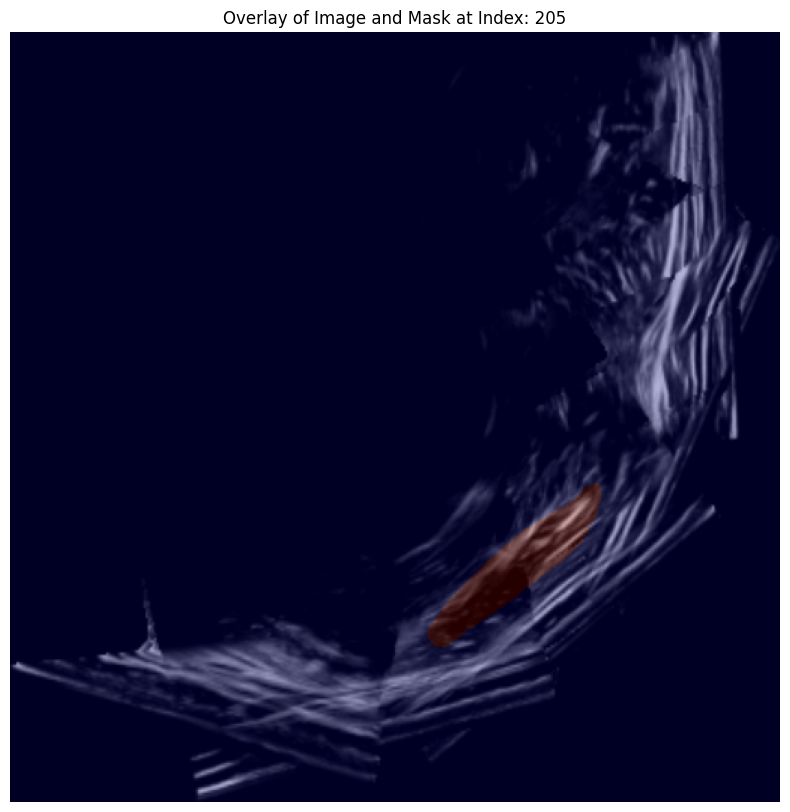

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to plot a random image with its corresponding mask overlay
def plot_random_image_with_mask_overlay(x_train, y_train):

    # Flatten the list of all images and masks for easy random selection
    all_images = [frame for video in x_train for frame in video]
    all_masks = [mask for video in y_train for mask in video if mask is not None]

    # Select a random index
    random_index = random.randint(0, min(len(all_images), len(all_masks)) - 1)

    # Retrieve the corresponding image and mask
    random_image = all_images[1]  # Image data
    random_mask = all_masks[1]    # Mask data

    # Ensure the image is 2D or convert it to 2D
    if random_image.ndim == 4:  # Case with shape like (3, 512, 512, 1)
        random_image = random_image[0, ..., 0]  # Take the first frame and remove the last dimension
    elif random_image.ndim == 3:  # Case with shape like (3, 512, 512)
        random_image = random_image[0, ...]  # Take the first frame

    # Ensure the mask is 2D (reduce dimensions if needed)
    if random_mask.ndim == 4:  # Case with shape like (3, 512, 512, 2)
        random_mask = random_mask[0, ..., 0]  # Select the first channel of the first frame
    elif random_mask.ndim == 3:  # Case with shape like (512, 512, 2)
        random_mask = random_mask[..., 0]  # Select the first channel


    # Plot the image with its mask overlay
    plt.figure(figsize=(10, 10))
    plt.title(f"Overlay of Image and Mask at Index: {random_index}")

    # Display the image
    plt.imshow(random_image, cmap='gray')

    # Overlay the mask with some transparency
    plt.imshow(random_mask, cmap='jet', alpha=0.3)  # Use 'jet' colormap to highlight the mask

    plt.axis('off')
    plt.show()

# Call the function to plot an image with its mask overlay
plot_random_image_with_mask_overlay(x_train, y_train)





## Load validation data

In [10]:
# Define directories for masks and videos
mask_directory = 'C:/Users/camen/Documents/Carla_Master_Thesis/Data_IFSS_crop/val_mask/'
video_directory = 'C:/Users/camen/Documents/Carla_Master_Thesis/Data_IFSS_crop/val_video/'
sub_vol_size = 3
last_ind = sub_vol_size-1

# Loading the masks
mask_dataset = []
m_dataset = []
mask_number_all = []

for path in glob.glob(os.path.join(mask_directory, "video*")):

    frame_mask_dataset = []
    mask_number = []

    for mask_path in glob.glob(os.path.join(path, "*.tif")):

        filename = os.path.splitext(os.path.basename(mask_path))[0]
        number = filename.split('_')[-1]
        number = int(number)
        mask_number.append(number)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (512,512))
        #mask = np.stack((mask, mask), axis=-1)
        mask = np.clip(np.where(mask>100, mask, 0), 0, 1)
        mask = np.expand_dims(mask, -1)
        mask = np.concatenate([mask, 1-mask], -1)
        mask = np.array(mask)
        #mask = mask/255.0
        frame_mask_dataset.append(mask)

    frame_mask_dataset = np.array(frame_mask_dataset)
    mask_dataset.append(frame_mask_dataset)
    mask_number_all.append(mask_number)

    stacked_masks_set = []

    # Used for fully supervised learning, comment stacked_masks_set and m_dataset for weakly supervised learning
    # Stack the frames to create a set of 3 frames
    stacked_masks_set = np.array([np.stack([frame_mask_dataset[i], frame_mask_dataset[i+1], frame_mask_dataset[i+2]], axis=0)
                               for i in range(len(frame_mask_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    m_dataset.append(stacked_masks_set)

# Loading and stacking the image frames
image_dataset = []
video_length = []

for path in glob.glob(os.path.join(video_directory, "video*")):

    frame_dataset = []

    for frame_path in glob.glob(os.path.join(path, "*.tif")):

        frame = cv2.imread(frame_path, 1)
        frame = cv2.resize(frame, (512,512))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = np.array(frame)/255.0
        frame_dataset.append(frame)

    frame_dataset = np.array(frame_dataset)
    single_video_length = len(frame_dataset)
    video_length.append(single_video_length)

    stacked_frames_set = []

     # Stack the frames to create a set of 3 frames
    stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    image_dataset.append(stacked_frames_set)

# Weakly supervised training
# Handling masks with missing data
#mask_dataset_complete = []

#for i in range(len(mask_number_all)):

#    target_length = video_length[i]
#    target_array = np.empty(target_length, dtype=object)
#    target_mask_set = mask_dataset[i]

#    for j in range(len(mask_number_all[i])):
#        target_array[mask_number_all[i][j]] = target_mask_set[j]

#    mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

# Fully supervised training
x_val = image_dataset
y_val = m_dataset
# Weakly supervised training
#x_val = np.array(image_dataset, dtype=object)
#y_val = mask_dataset_complete


## Training loop

In [11]:
# Variable definitions
#loss_object = tf.keras.losses.binary_crossentropy

optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.Accuracy()
val_acc_metric = tf.keras.metrics.Accuracy()
train_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)
val_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)

epochs = 100

# Define ModelCheckpoint class
class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='min'):
        super(ModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best = np.inf if mode == 'min' else -np.inf
        self.mode = mode

        if mode not in ['auto', 'min', 'max']:
            print(f"ModelCheckpoint mode {mode} is unknown, fallback to auto mode.")
            self.mode = 'auto'

        if self.mode == 'min':
            self.monitor_op = np.less
        elif self.mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            print(f"Warning: Monitor value {self.monitor} is not available in logs. Skipping checkpoint saving.")
            return

        filepath = self.filepath.format(epoch=epoch)

        if self.save_best_only:
            if self.monitor_op(current, self.best):
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {filepath}")
                self.best = current
                self.model.save(filepath)
            else:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch}: {self.monitor} did not improve from {self.best:.5f}")
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch}: saving model to {filepath}")
            self.model.save(filepath)

# Define CSVLogger class
class CSVLogger(tf.keras.callbacks.Callback):
    def __init__(self, filename, separator=',', append=False):
        super(CSVLogger, self).__init__()
        self.filename = filename
        self.sep = separator
        self.append = append
        self.keys = None
        self.append_header = not append or not os.path.exists(filename)
        self.file_flags = 'a' if append else 'w'

    def on_train_begin(self, logs=None):
        self.csv_file = open(self.filename, self.file_flags, newline='')
        self.writer = csv.writer(self.csv_file, delimiter=self.sep)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if self.keys is None:
            self.keys = sorted(logs.keys())
            if self.append_header:
                self.writer.writerow(['epoch'] + self.keys)

        row = [epoch] + [logs[k] for k in self.keys]
        self.writer.writerow(row)
        self.csv_file.flush()

    def on_train_end(self, logs=None):
        self.csv_file.close()

# Define EarlyStoppingCallback class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_delta=0, patience=0):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.best = float('inf')
        self.wait = 0
        self.stopped_epoch = 0


    def on_epoch_end(self, epoch, logs):
        current = logs.get('val_loss')
        if current is None:
            return

        # Update the best validation loss
        if current < self.best - self.min_delta:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.hasattr(self.model, 'stop_training'):
                    self.model.stop_training = True
                print(f"Epoch {epoch}: early stopping")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Training stopped early at epoch {self.stopped_epoch}")

# Define ReduceLROnPlateauCallback class
class ReduceLROnPlateauCallback(tf.keras.callbacks.Callback):
    def __init__(self, factor=0.1, min_lr=0.0000001, patience=4, threshold=0.0001):
        super().__init__()
        self.factor = factor
        self.min_lr = min_lr
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best = float('inf')

    def on_epoch_end(self, epoch, logs):
        current = logs.get('val_loss')
        if current is None:
            return

        current_lr = optimizer.learning_rate.numpy()

        # initialize or update the best validation loss
        if current < self.best - self.threshold:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # reduce the learning rate
                new_lr = max(current_lr * self.factor, self.min_lr)
                optimizer.learning_rate.assign(new_lr)
                print(f"Epoch {epoch}: reducing learning rate to {new_lr:.6f}")
                self.wait = 0

# Define functions to validate data
@tf.function
def val_step(x_val, y_val):

    output_masks = model([x_val, y_val], training = False)
    #val_loss = loss_object(y_val[:, 1:3, :, :, :], output_masks[:, :2, :, :, :])
    val_loss_1 = focal_tversky(y_val[:, 1:2, :, :, :], output_masks[:, :1, :, :, :])
    val_loss_2 = focal_tversky(y_val[:, 2:3, :, :, :], output_masks[:, 1:2, :, :, :])
    val_loss = (val_loss_1 + val_loss_2)/2
    dice_sim_coeff_1 = dsc(y_val[:, 1:2, :, :, :1], output_masks[:, :1, :, :, :1])
    dice_sim_coeff_2 = dsc(y_val[:, 2:3, :, :, :1], output_masks[:, 1:2, :, :, :1])
    dice_sim_coeff = (dice_sim_coeff_1 + dice_sim_coeff_2)/2
    hdd_1 = HausdorffDistance(y_val[:, 1:2, :, :, :1], output_masks[:, :1, :, :, :1])
    hdd_2 = HausdorffDistance(y_val[:, 2:3, :, :, :1], output_masks[:, 1:2, :, :, :1])
    hdd = (hdd_1 + hdd_2) / 2

    val_acc_metric.update_state(y_val[:, 1:3, :, :, :1], output_masks[:, :2, :, :, :1])
    val_iou_metric.update_state(y_val[:, 1:3, :, :, :1], output_masks[:, :2, :, :, :1])

    return val_loss, dice_sim_coeff, hdd, output_masks

def val_model(x_val, y_val):

    total_val_loss = []
    total_dice_sim_coeff = []
    total_hdd = []

    for batch_idx in range(len(x_val)):

        x_batch = x_val[batch_idx]
        y_batch = y_val[batch_idx] # in validation only a few input masks to beginn with

        for step in range(len(x_batch)):

            x_images = x_batch[step]
            x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

            # weakly supervised training
            #if step == 0 or step == 1:
            #    y_masks = np.stack(y_batch[0:3], axis=0)
            #if step == 2:
            #    y_masks = y_masks.copy()
            #    y_masks[0] = y_batch[1]
            #    y_masks[1] = y_batch[2]
            #if step == 3:
            #    y_masks = y_masks.copy()
            #    y_masks[0] = y_batch[2]

            # fully supervised training
            y_masks = y_batch[step]
            # from here used by both fully and weakly supervised training
            y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))

            val_loss, dice_sim_coeff, hdd, output_masks = val_step(x_images, y_masks)
            output_masks = tf.clip_by_value(output_masks, 0, 1)

            total_val_loss.append(val_loss)
            total_dice_sim_coeff.append(dice_sim_coeff)
            total_hdd.append(hdd)

            # weakly supervised training
            #y_masks = output_masks.numpy()
            #y_masks = y_masks.reshape((y_masks.shape[1], y_masks.shape[2], y_masks.shape[3], y_masks.shape[4]))

    val_acc = val_acc_metric.result()
    val_iou = val_iou_metric.result()
    print(f"Accuracy over Validation Set: {val_acc} | IoU over Validation Set: {val_iou}")
    val_acc_metric.reset_state()
    val_iou_metric.reset_state()

    return np.mean(total_val_loss), np.mean(total_dice_sim_coeff), np.mean(total_hdd)

# Define functions to train model
@tf.function
def train_step(start_images, start_masks):

    with tf.GradientTape() as tape:
        # Forward pass
        output_masks = model([start_images, start_masks], training = True)
        #loss = loss_object(start_masks[:, 1:3, :, :, :], output_masks[:, :2, :, :, :])
        loss_1 = focal_tversky(start_masks[:, 1:2, :, :, :], output_masks[:, :1, :, :, :])
        loss_2 = focal_tversky(start_masks[:, 2:3, :, :, :], output_masks[:, 1:2, :, :, :])
        loss = (loss_1 + loss_2)/2

    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    train_acc_metric.update_state(start_masks[:, 1:3, :, :, :1], output_masks[:, :2, :, :, :1])
    train_iou_metric.update_state(start_masks[:, 1:3, :, :, :1], output_masks[:, :2, :, :, :1])

    return loss, output_masks

def train_model(x_train, y_train, x_val, y_val, epochs):

    early_stopping = EarlyStoppingCallback(patience=20)

    reduce_lr = ReduceLROnPlateauCallback(factor=0.1, min_lr=0.0000001, patience=5) #

    checkpoint_callback = ModelCheckpoint(filepath='IFSS_checkpoint_epoch{epoch:02d}.weights.h5', monitor='val_loss', save_best_only=True, verbose=1)
    checkpoint_callback.set_model(model)

    csv_logger = CSVLogger(filename='training_log.csv', separator=',', append=False)
    csv_logger.on_train_begin()

    total_batches = len(x_train) * len(x_train[0])  # Total number of batches across steps

    for epoch in range(epochs):
        print(f"Start of training epoch: {epoch}")

        total_loss = []

        # Create a progress bar for the current epoch with the total number of batches
        with tqdm(total=total_batches, desc=f"Epoch {epoch+1}/{epochs} ({total_batches} batches)", unit="batch") as pbar:
            for batch_idx in range(len(x_train)):
                x_batch = x_train[batch_idx]
                y_batch = y_train[batch_idx]

                for step in range(len(x_batch)):

                    x_images = x_batch[step]
                    x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

                    # weakly supervised training
                    #if step == 0:
                    #    y_masks = np.stack(y_batch[0:3], axis=0)
                    #else:
                    #    y_masks = y_masks.copy()
                    #    if y_batch[step-1] is not None:
                    #        y_masks[0] = y_batch[step-1]
                    #    if y_batch[step] is not None:
                    #        y_masks[1] = y_batch[step]
                    #    if y_batch[step+1] is not None:
                    #        y_masks[2] = y_batch[step+1]

                    # fully supervised training
                    y_masks = y_batch[step]
                    # from here used by both fully and weakly supervised training
                    y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))
                    #x_tensor = tf.convert_to_tensor(x_images, dtype=tf.float32)
                    #y_tensor = tf.convert_to_tensor(y_masks, dtype=tf.int64)
                    loss, output_masks = train_step(x_images, y_masks)
                    output_masks = tf.clip_by_value(output_masks, 0, 1)
                    total_loss.append(loss)

                    # weakly supervised training
                    #y_masks = output_masks.numpy()
                    #y_masks = y_masks.reshape((y_masks.shape[1], y_masks.shape[2], y_masks.shape[3], y_masks.shape[4]))

                    # Update the progress bar after each step
                    pbar.update(1)

        # Calculate metrics for the current epoch
        train_acc = train_acc_metric.result()
        train_iou = train_iou_metric.result()
        print(f"Accuracy over epoch {epoch} : {train_acc} | IoU over epoch {epoch} : {train_iou}")
        train_acc_metric.reset_state()
        train_iou_metric.reset_state()

        print(f'Epoch {epoch}, Loss: {np.mean(total_loss)}')

        # Validation loss for the current epoch
        val_loss_epoch, dice_sim_coeff_epoch, hdd_epoch = val_model(x_val, y_val)

        logs = {'val_loss': np.array(val_loss_epoch),
                'accuracy': train_acc.numpy(),
                'iou': train_iou.numpy(),
                'tversky_loss': np.mean(total_loss),
                'val_dice_similarity_coefficient': np.array(dice_sim_coeff_epoch),
                'hausdorff_distance': np.array(hdd_epoch)}

        # Callback functions
        early_stopping.on_epoch_end(epoch, logs=logs)
        reduce_lr.on_epoch_end(epoch, logs=logs)
        checkpoint_callback.on_epoch_end(epoch, logs=logs)
        csv_logger.on_epoch_end(epoch, logs=logs)

    csv_logger.on_train_end()

train_model(x_train, y_train, x_val, y_val, epochs=epochs)


Start of training epoch: 0


Epoch 1/100 (310 batches): 100%|██████████| 310/310 [02:52<00:00,  1.79batch/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy over epoch 0 : 0.014024980366230011 | IoU over epoch 0 : 0.49912017583847046
Epoch 0, Loss: 0.5112099051475525
Accuracy over Validation Set: 0.0 | IoU over Validation Set: 0.0

Epoch 0: val_loss did not improve from inf
Start of training epoch: 1


Epoch 2/100 (310 batches): 100%|██████████| 310/310 [02:01<00:00,  2.56batch/s]


Accuracy over epoch 1 : 0.02356468327343464 | IoU over epoch 1 : 0.5414223670959473
Epoch 1, Loss: 0.3943503201007843
Accuracy over Validation Set: 0.0 | IoU over Validation Set: 0.0

Epoch 1: val_loss did not improve from inf
Start of training epoch: 2


Epoch 3/100 (310 batches): 100%|██████████| 310/310 [02:00<00:00,  2.57batch/s]


Accuracy over epoch 2 : 0.03630486875772476 | IoU over epoch 2 : 0.597554087638855
Epoch 2, Loss: 0.35318121314048767
Accuracy over Validation Set: 0.0 | IoU over Validation Set: 0.0

Epoch 2: val_loss did not improve from inf
Start of training epoch: 3


Epoch 4/100 (310 batches): 100%|██████████| 310/310 [02:00<00:00,  2.57batch/s]


Accuracy over epoch 3 : 0.045148301869630814 | IoU over epoch 3 : 0.6364669799804688
Epoch 3, Loss: 0.3301423192024231
Accuracy over Validation Set: 0.0 | IoU over Validation Set: 0.0

Epoch 3: val_loss did not improve from inf
Start of training epoch: 4


Epoch 5/100 (310 batches): 100%|██████████| 310/310 [02:00<00:00,  2.57batch/s]


Accuracy over epoch 4 : 0.05076911672949791 | IoU over epoch 4 : 0.661229133605957
Epoch 4, Loss: 0.31161871552467346
Accuracy over Validation Set: 0.0 | IoU over Validation Set: 0.0
Epoch 4: reducing learning rate to 0.000100

Epoch 4: val_loss did not improve from inf
Start of training epoch: 5


Epoch 6/100 (310 batches):  11%|█         | 34/310 [00:13<01:49,  2.52batch/s]


KeyboardInterrupt: 

Load testing data

In [ ]:
mask_directory = 'C:/Users/admin/Documents/DL_Track/IFSS_Net/Data/Data/test_mask/'
video_directory = 'C:/Users/admin/Documents/DL_Track/IFSS_Net/Data/Data/test_video/'

sub_vol_size = 3
last_ind = sub_vol_size-1

mask_dataset = []
mask_number_all = []

for path in glob.glob(os.path.join(mask_directory, "video*")):

    frame_mask_dataset = []
    mask_number = []

    for mask_path in glob.glob(os.path.join(path, "*.tif")):

        filename = os.path.splitext(os.path.basename(mask_path))[0]
        number = filename.split('_')[-1]
        number = int(number)
        mask_number.append(number)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (512,512))
        #mask = np.stack((mask, mask), axis=-1)
        mask = np.clip(np.where(mask>100, mask, 0), 0, 1)
        mask = np.expand_dims(mask, -1)
        mask = np.concatenate([mask, 1-mask], -1)
        mask = np.array(mask)
        #mask = mask/255.0
        frame_mask_dataset.append(mask)

    frame_mask_dataset = np.array(frame_mask_dataset)
    mask_dataset.append(frame_mask_dataset)
    mask_number_all.append(mask_number)

image_dataset = []
video_length = []

for path in glob.glob(os.path.join(video_directory, "video*")):

    frame_dataset = []

    for frame_path in glob.glob(os.path.join(path, "*.tif")):

        frame = cv2.imread(frame_path, 1)
        frame = cv2.resize(frame, (512,512))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.reshape((frame.shape[0], frame.shape[1], 1))
        frame = np.array(frame)/255.0
        frame_dataset.append(frame)

    frame_dataset = np.array(frame_dataset)
    single_video_length = len(frame_dataset)
    video_length.append(single_video_length)

    # Stack the frames to create a set of 3 frames
    stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
                               for i in range(len(frame_dataset) - last_ind)])

    # Append the stacked frames set directly to the image dataset
    image_dataset.append(stacked_frames_set)


#mask_dataset_complete = []

#for i in range(len(mask_number_all)):

    #target_length = video_length[i]
    #target_array = np.empty(target_length, dtype=object)
    #target_mask_set = mask_dataset[i]

    #for j in range(len(mask_number_all[i])):
        #target_array[mask_number_all[i][j]] = target_mask_set[j]

    #mask_dataset_complete.append(target_array)

#mask_dataset_complete = np.array(mask_dataset_complete, dtype=object)

x_test = image_dataset
#y_test = mask_dataset_complete
y_test = mask_dataset

Testing loop

In [ ]:
# functions to test accuracy of IFSS-Model over test data
# input video test data (22, 3, 512, 512, 1)-> 22 arrays each containing 3 consecutive video frames
# input mask test data (3, 512, 512, 1)-> 3 labelled masks of the first 3 video frames

from tensorflow.keras.models import load_model


model = load_model('IFSS_checkpoint_epoch04.weights.h5', custom_objects={'focal_tversky': focal_tversky, 'IoU': IoU})

test_acc_metric = tf.keras.metrics.Accuracy()
test_iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)

# define functions to test data
@tf.function
def test_step(x_test, y_test):
    output_masks = model([x_test, y_test], training = False)
    test_acc_metric.update_state(y_test[:, 1:3, :, :, :1], output_masks[:, :2, :, :, :1])
    test_iou_metric.update_state(y_test[:, 1:3, :, :, :1], output_masks[:, :2, :, :, :1])

    return output_masks

def test_model(x_test, y_test):

    for batch_idx in range(len(x_test)):

        x_batch = x_test[batch_idx]
        y_batch = y_test[batch_idx] # in testing only a few input masks to beginn with

        for step in range(len(x_batch)):

            x_images = x_batch[step]
            x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

            if step == 0 or step == 1:
                y_masks = np.stack(y_batch[0:3], axis=0)
            if step == 2:
                y_masks = y_masks.copy()
                y_masks[0] = y_batch[1]
                y_masks[1] = y_batch[2]
            if step == 3:
                y_masks = y_masks.copy()
                y_masks[0] = y_batch[2]

            y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))

            output_masks = test_step(x_images, y_masks)
            y_masks = tf.clip_by_value(output_masks, 0, 1) # Clip values between 0 and 1

            y_masks = output_masks.numpy()
            y_masks = y_masks.reshape((y_masks.shape[1], y_masks.shape[2], y_masks.shape[3], y_masks.shape[4]))

    test_acc = test_acc_metric.result()
    test_iou = test_iou_metric.result()
    print(f"Accuracy over Test Set: {test_acc} | IoU over Test Set: {test_iou}")
    test_acc_metric.reset_state()

test_model(x_test, y_test)

## Load data for prediction

In [ ]:
mask_directory = 'C:/Users/camen/Documents/Carla_Master_Thesis/Data_IFSS/pred_mask/video_2/'
video_directory = 'C:/Users/camen/Documents/Carla_Master_Thesis/Data_IFSS/pred_video/video_2/'

#model = load_model('IFSS_checkpoint_epoch09.weights.h5', custom_objects={'focal_tversky': focal_tversky, 'IoU': IoU})

#mask_directory = 'C:/Users/admin/Documents/DL_Track/IFSS_Net/Data/Data/IFSSconv/val_mask/video_1/'
#video_directory = 'C:/Users/admin/Documents/DL_Track/IFSS_Net/Data/Data/IFSSconv/val_video/video_1/'
# Profiling start
#start_time = time.time()

# Loading masks
predict_mask = []
mask_number = []

mask_paths = glob.glob(os.path.join(mask_directory, "*.tif"))
print(f"Number of mask files: {len(mask_paths)}")

for mask_path in mask_paths:
    filename = os.path.splitext(os.path.basename(mask_path))[0]
    number = int(filename.split('_')[-1])
    mask_number.append(number)

    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (512, 512))  # Resizing to 512x512
    #mask = np.stack((mask, mask), axis=-1)  # Duplicate the mask for some reason
    mask = np.clip(np.where(mask>100, mask, 0), 0, 1)
    mask = np.expand_dims(mask, -1)
    mask = np.concatenate([mask, 1-mask], -1)
    #mask = mask / 255.0  # Normalize to [0,1]
    predict_mask.append(mask)

predict_mask = np.array(predict_mask)
#print(f"Time for loading and processing masks: {time.time() - start_time:.2f} seconds")

# Loading frames
#start_time = time.time()

frame_set = []
frame_paths = glob.glob(os.path.join(video_directory, "*.tif"))
print(f"Number of video frames: {len(frame_paths)}")

for frame_path in frame_paths:
    frame = cv2.imread(frame_path, 1)
    frame = cv2.resize(frame, (512, 512))  # Resize to 512x512
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    frame = frame.reshape((frame.shape[0], frame.shape[1], 1))  # Reshape to (512,512,1)
    frame = frame / 255.0  # Normalize to [0,1]
    frame_set.append(frame)

frame_set = np.array(frame_set)
#print(f"Time for loading and processing frames: {time.time() - start_time:.2f} seconds")

# Stacking frames
#start_time = time.time()
stacked_frames = []

# Stack the frames to create a set of 3 frames
#stacked_frames_set = np.array([np.stack([frame_dataset[i], frame_dataset[i+1], frame_dataset[i+2]], axis=0)
#                            for i in range(len(frame_dataset) - last_ind)])
stacked_frames_set = np.array([np.stack([frame_set[i], frame_set[i+1], frame_set[i+2]], axis=0)
                            for i in range(len(frame_set) - last_ind)])

# Append the stacked frames set directly to the image dataset
stacked_frames.append(stacked_frames_set)

predict_video = np.array(stacked_frames_set)
#print(f"Time for stacking frames: {time.time() - start_time:.2f} seconds")

Number of mask files: 3
Number of video frames: 81


## Prediction loop

In [ ]:
# functions to predict masks from a video
# input video shape (22, 3, 512, 512, 1)-> 22 arrays each containing 3 consecutive video frames, in total 24 frames
# input mask shape (3, 512, 512, 2)-> 3 labelled masks for the first 3 video frames
# step size = 1

import time


@tf.function
def predict_step(x_data, y_data):
    output_masks = model([x_data, y_data], training=False)
    return output_masks

def predict_model(x_data, y_data):
    predictions = []

    for step in range(len(x_data)): # range(0, len(x_data), 3)
        x_images = x_data[step]
        x_images = x_images.reshape((1, x_images.shape[0], x_images.shape[1], x_images.shape[2], x_images.shape[3]))

        if step == 0 or step == 1:
            y_masks = np.stack(y_data[0:3], axis=0)
        if step == 2:
            y_masks = y_masks.copy()
            y_masks[0] = y_data[1]
            y_masks[1] = y_data[2]
        if step == 3:
            y_masks = y_masks.copy()
            y_masks[0] = y_data[2]

        y_masks = y_masks.reshape((1, y_masks.shape[0], y_masks.shape[1], y_masks.shape[2], y_masks.shape[3]))

        output_masks = predict_step(x_images, y_masks)
        output_masks = tf.clip_by_value(output_masks, 0, 1)
        y_masks = output_masks.numpy()
        y_masks = y_masks.reshape((y_masks.shape[1], y_masks.shape[2], y_masks.shape[3], y_masks.shape[4]))

        selected_output = y_masks[1, :, :, :]
        predictions.append(selected_output)

    return predictions

start_time = time.time()

predictions = predict_model(predict_video, predict_mask)
np.save('valset_2_total_crop', predictions)
end_time = time.time()
total_time = end_time - start_time
print(total_time)

27.568928718566895


## Plotting of predictions

(79, 512, 512, 2)


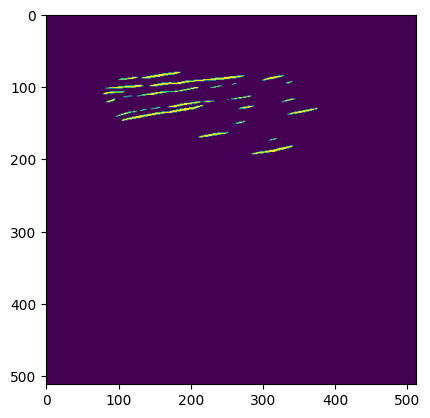

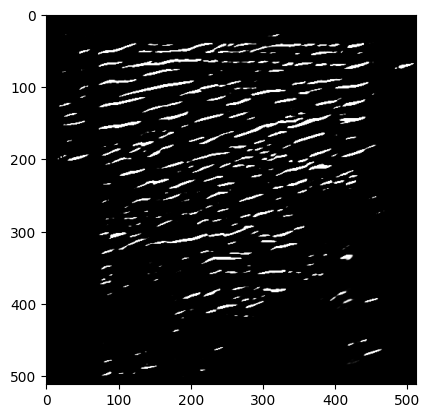

In [ ]:
predictions = np.array(predictions)
threshold = 0.00
predictions_thresh = (predictions > threshold).astype(np.float32)
print(predictions_thresh.shape)


plt.imshow(predictions[0, :, :, 0])
plt.show()
plt.imshow(predictions[5, :, :, 0], cmap='gray')
plt.show()

(79, 512, 512, 2)
1.0


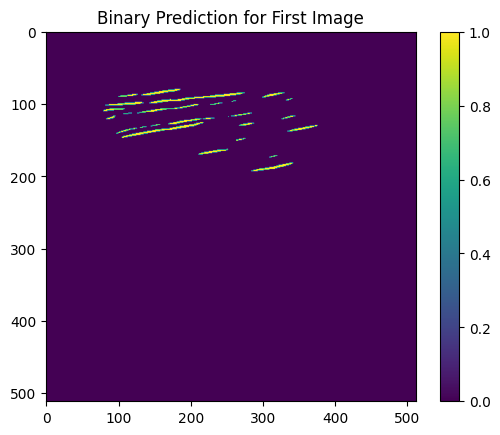

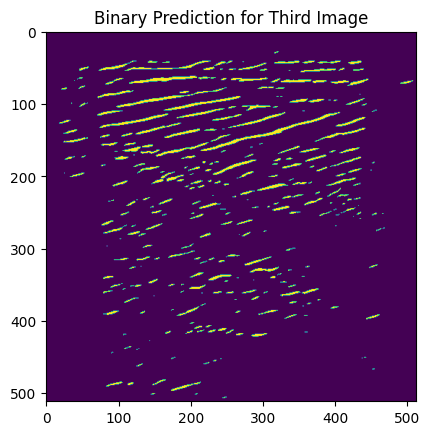

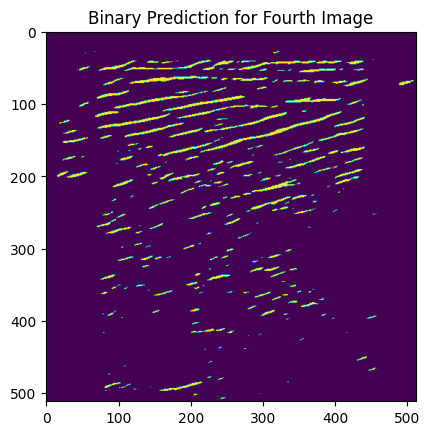

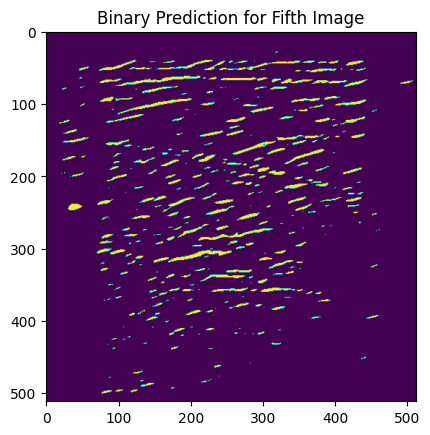

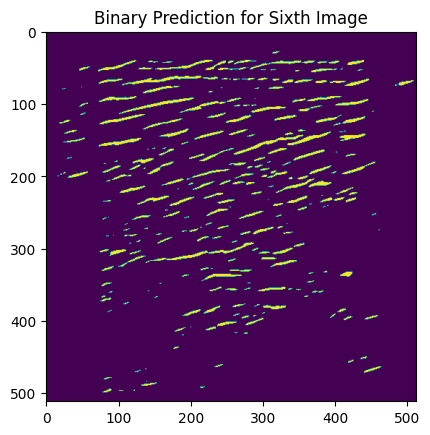

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the predictions are in the range [0, 1], not [0, 255]
predictions = np.array(predictions)

# Apply threshold for binary prediction (0.5 is typical for probabilities in range [0, 1])
threshold = 0.5
predictions_thresh = (predictions > threshold).astype(np.float32)

# Print the shape of the binary predictions
print(predictions_thresh.shape)
print(np.max(predictions[0, :, :, 0]))

# Visualize the first prediction (binary mask)
im = plt.imshow(predictions_thresh[0, :, :, 0], cmap='viridis')
plt.colorbar(im)
plt.title("Binary Prediction for First Image")
plt.show()

# Visualize the second prediction (binary mask)
plt.imshow(predictions_thresh[2, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Third Image")
plt.show()

plt.imshow(predictions_thresh[3, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Fourth Image")
plt.show()

plt.imshow(predictions_thresh[4, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Fifth Image")
plt.show()

plt.imshow(predictions_thresh[5, :, :, 0], cmap='viridis')
plt.title("Binary Prediction for Sixth Image")
plt.show()




In [ ]:
import nrrd

def load_and_preprocess_volumes(volume_file, mask_file, num_classes, patch_size=None):
    x_data = []
    y_data = []

        # load vol and mask
    volume_data, _= nrrd.read(volume_file)
    mask_data, _ = nrrd.read(mask_file)

        # normalizing the vol
    volume_data = (volume_data - np.min(volume_data)) / (np.max(volume_data) - np.min(volume_data))

    volume_data = np.expand_dims(volume_data, axis=-1)  # adds the channel
    volume_data = np.expand_dims(volume_data, axis=0)  # adds the batch

    # One-hot encoding of mask
    mask_data_onehot = np.eye(num_classes)[mask_data] # one-hot encoding
    mask_data_onehot = np.expand_dims(mask_data_onehot, axis=0) # <dds batch

    x_data.append(volume_data)
    y_data.append(mask_data_onehot)

    return np.array(x_data), np.array(y_data)

# Esempio di utilizzo
volume_file = "C:/Users/diego/Bac Sport and Computer Science/Documents/BA-arbeit/RepoBA/VL_009_MZP2.nrrd"
mask_file = "C:/Users/diego/Bac Sport and Computer Science/Documents/BA-arbeit/RepoBA/Segmentation_VL_009_MZP2.seg.nrrd"
patch_size = (16, 128, 128)  # Dividi i volumi in patch di dimensioni (depth, height, width)

x_train, y_train = load_and_preprocess_volumes(volume_file, mask_file, num_classes=21, patch_size=patch_size)
#x_val, y_val = load_and_preprocess_volumes("path_to_val_volumes", "path_to_val_masks", num_classes=2, patch_size=patch_size)

print(f"Forma x_train: {x_train.shape}, y_train: {y_train.shape}")


MemoryError: Unable to allocate 24.6 GiB for an array with shape (730, 530, 407, 21) and data type float64

In [ ]:
# Percorsi ai file
volume_path = "C:/Users/diego/Bac Sport and Computer Science/Documents/BA-arbeit/RepoBA/VL_009_MZP2.nrrd"
mask_path = "C:/Users/diego/Bac Sport and Computer Science/Documents/BA-arbeit/RepoBA/Segmentation_VL_009_MZP2.seg.nrrd"

# Caricamento dei dati
volume_data, _ = nrrd.read(volume_path)  # Carica il volume
mask_data, _ = nrrd.read(mask_path)      # Carica la maschera

# Normalizza il volume tra 0 e 1
volume_data = (volume_data - np.min(volume_data)) / (np.max(volume_data) - np.min(volume_data))

# Aggiungi dimensioni batch e canale al volume
volume_data = np.expand_dims(volume_data, axis=-1)  # Aggiungi canale
volume_data = np.expand_dims(volume_data, axis=0)   # Aggiungi batch

# Converte la maschera in formato one-hot
num_classes = 22
mask_data_onehot = np.eye(num_classes)[mask_data]  # One-hot encoding
mask_data_onehot = np.expand_dims(mask_data_onehot, axis=0)  # Aggiungi batch

# Stampa le forme finali
print("Forma del volume:", volume_data.shape)        # (1, depth, height, width, 1)
print("Forma della maschera:", mask_data_onehot.shape)  # (1, depth, height, width, num_classes)


Forma del volume: (1, 730, 530, 407, 1)
Forma della maschera: (1, 730, 530, 407, 22)
